In [1]:
import numpy as np

import torch
import torch.optim as optim
from torch import nn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from tqdm import tqdm

from scipy.linalg import block_diag
from scipy.special import binom

from itertools import combinations

from analysis import bootstrap

from typing import Callable
from numpy.typing import ArrayLike

### Remarks

* [wrapped normal distributions](https://mpmath.org/doc/0.19/functions/elliptic.html#jacobi-theta-functions)



### Deformation Space

Recall that the following three spaces are all diffeomorphic 

$$Q = \{ z \in \mathbb{C}^{n+1} \mid \sum_k z_k^2 = 1 \}$$

$$TS^n = \{ (x,y) \mid x \in S^n, \langle x , y \rangle = 0\}$$

$$S^n \times S^n / \Delta = \{(u,v) \mid u,v \in S^n, u \neq v \}$$

The diffeomorphism are given by 

$$\Psi \colon TS^n \to Q \quad , \quad (x,y) \mapsto (x \sqrt{1 + \lVert y \rVert^2} + i y)$$

and 

$$\Phi \colon S^n \times S^n / \Delta \to TS^n \quad , \quad (u,v) \mapsto \left(u, \frac{v - \langle u, v\rangle u}{1 - \langle u, v\rangle}\right)$$

### The Model

For $z,w$ in $\mathbb{CP}^n$: 

$$S(z,w) = -\beta \sum_{a,b} z_a \bar z_b w_b \bar w_a$$

Now, forget about the $U(1)$ invariance (can be integrated out since compact) and fix the non-compact part of the $\mathbb{C}^*$ gauge group via 

$$\delta( \lvert z \rvert^2 - 1)  \delta( \lvert w \rvert^2 - 1)$$ 

with 

$$\lvert z \rvert^2 = \sum_a \lvert z_a \rvert^2$$

Rewrite it in real variables: let $z_a = x_a + i y_a$, $w_a = u_a + i v_a$ and define _real_ vectors $Z = (\dots,x_a,y_a,\dots)$ and $W = (\dots,u_a,v_a,\dots)$ with $\lVert Z \rVert^2 = 1$ and likewise for $W$.

Define $h = id + J$ where $J = diag(\sigma_y, \dots, \sigma_y)$ where 

$$\sigma_y = \begin{pmatrix} 0 & -i \\ i & 0\end{pmatrix}$$

Then 

$$S(Z,W) = \beta \langle Z , T W \rangle \langle W , T Z \rangle$$

where $\langle \dots \rangle$ is the standard inner product in $\mathbb{R}^{2n+2}$.


In [ ]:
# DIFFEOMORPHISMS TS^n <-> Q <-> S^n x S^n / Delta

def Psi(p): # TS^n -> Q
    x, y = p # unpack point (into base point x, tangent vector y)

    z = x*np.sqrt(1 + np.inner(y,y)) + y*1j

    return z

def invPsi(z): # Q -> TS^n
    re, im = (z.real,z.imag) # seperate into re and im part
    
    x = re / np.sqrt(1 + np.inner(im,im))
    y = im
    
    return (x,y)

def Phi(p): # S^n x S^n / Delta -> TS^n
    u, v = p # unpack p

    x = u # base point
    y = (v - np.inner(u,v)*u) / (1 - np.inner(u,v)) # tangent vector 

    return (x,y)

def invPhi(p): # TS^n -> S^n x S^n / Delta
    x,y = p # unpack base point, tangent vector

    u = x
    v = (x*(np.inner(y,y) - 1) + 2*y ) / (np.inner(y,y) + 1)

    return u, v


# HERMITIAN INNER PRODUCT 

def h(n:int,Z:np.ndarray,W:np.ndarray) -> np.ndarray:
    """ 
    Quadratic form h used in action functional 

    :param n: complex dimension of CP^n
    :type n: int

    :param Z: (samples,2n + 2,1) real column vector 
    :type Z: np.ndarray

    :param W: (samples,2n + 2,1) real column vector 
    :type W: np.ndarray

    :returns: h(Z,W) for each sample
    :rtype: np.ndarray
    """
    id = np.eye(2*(n + 1))

    sigma_y = np.array([[0,-1j],[1j,0]])

    J = block_diag(*[sigma_y for _ in range(n+1)])

    # result = np.inner(Z.flatten(), ((id + J) @ W).flatten())
    result = ( Z.transpose(0,-1,1) @ ( (id + J) @ W) ).flatten()

    return result

def Scmplx(z:complex,w:complex,beta:float) -> float:
    return  - beta * np.inner(z,w.conjugate()) * np.inner(w, z.conjugate())

# TOY MODEL ACTION FUNCTIONAL

def S(n:int, Z:np.ndarray,W:np.ndarray,beta:float) -> float: # action on real variables
    return  - beta * h(n,Z,W) * h(n,W,Z)

# 2X2 ROTATION MATRIX FOR SAMPLING SPHERE
def R(t:float) -> np.ndarray:
    """
    2x2 roation matrix 

    :param t: rotation angle
    :type t: float

    :returns: rotation matrix np.array([[cos(t),-sin(t)],[sin(t),cos(t)]])
    :rtype: np.ndarray
    """

    c = np.cos(t)
    s = np.sin(t)

    return np.array([[c,-s],[s,c]])

# LINEAR ALGEBRA

def inner(a,X): # inner product <X,a>
    """
    shape X,a = (samples, 2n + 2, 1)
    """

    assert X.shape == a.shape
    assert len(X.shape) == 3
    assert X.shape[-1] == 1

    return X.transpose(0,-1,1) @ a

def outer(a,X): # outer product 
    """
    shape X,a = (samples, 2n + 2, 1)
    """

    assert X.shape == a.shape
    assert len(X.shape) == 3
    assert X.shape[-1] == 1

    return a * X.transpose(0,-1,1) 

def proj(a,X): # projection onto X

    inner_Xa = inner(X,a)
    
    return inner_Xa * X / inner(X,X)

def proj_perp(a,X): # proj perpendicular 
    return a - proj(a,X)

# JACOBIAN TOY MODEL

def M(a,X):
    """
    shape X,a = (samples, 2n + 2, 1)
    """

    assert X.shape == a.shape
    assert len(X.shape) == 3
    assert X.shape[-1] == 1

    id = np.eye(X.shape[1])

    inner_Xa = inner(X,a)
    inner_XX = inner(X,X)

    return  - id * inner_Xa  - outer(a,X) / inner_XX +  2*inner_Xa * outer(X,X) / inner_XX**2

def Jac(a,X):

    m = X.shape[1] # = 2n + 2

    Y = proj_perp(a,X)

    lam = np.sqrt(1 + inner(Y,Y)) # shape (samples,1,1)

    id = np.eye(X.shape[1])

    MM = M(a,X)

    J = id*lam + outer( (MM @ Y), X) / lam + 1j*MM

    det = np.linalg.det(J) # shape (samples,)

    return det / lam.flatten()**2 #(lam - 1j * inner(a,X))**(m-1)  # WHY DONT WE HAVE TO RETURN det / lam.flatten()**2 ? the extra factor should come from the delta function constraint

# COMPLEXIFICATION 

def tildeZ(a,X): # paramerisation of (analytical continuation of) Z

    Y = proj_perp(a,X)

    return X * np.sqrt(1 + inner(Y,Y)) + 1j*Y

# MCMC

def sweep_sphere(phi:list,pairs:list,f) -> int:  
    """
    sweeping the sphere

    :param n: complex dimension CP^n
    :type n: int
    """

    alpha = 0 # number accepted

    # LOOP OVER COMPONENTS 
    for pair in pairs:
        a,b = pair # unpack indices
        phi_old = phi[-1] # current state 

        # SAMPLE 2x2 ROTATION ANGLE
        theta = np.random.normal(loc=0,scale=1)

        # ROTATE COMPONENT
        v = np.array([phi_old[a],phi_old[b]])
        vnew = R(theta) @ v

        # PROPOSE NEW STATE
        phi_new = phi_old.copy()
 
        phi_new[a] = vnew[0]
        phi_new[b] = vnew[1]
    
        # ACCEPTENCE PROBABILITIES
        A = np.minimum(1, f(phi_new[np.newaxis,:,:]) / (f(phi_old[np.newaxis,:,:])) ) # newaxis since f takes list of vectors: shape = (smaples,2n+2,1)

        # CHECK IF ACCEPTED
        p = np.random.uniform(low=0,high=1) # draw vector of uniform rnds
        
        if p <= A : # accept if p < A
            phi.append(phi_new)
            alpha += 1
        else:
            phi.append(phi_old)

    return alpha / len(pairs)


def MCMC_toy(n:int, Z0:complex,W0:complex,beta:float,N_steps:int,burnin:int,k:int) -> tuple[np.ndarray,float,np.ndarray]:
    """
    :param n: complex dimension CP^n 
    :type n: int
    """

    N = 2*n + 2 # real dimension (before quotient by C^*)
    pairs = list(combinations(np.arange(N),2)) # indices of pairs to rotate

    # SETUP
    Z = [Z0] 
    W = [W0]

    alpha = 0 # number accepted

    expSw = lambda z: np.exp( -S(n,z,W[-1][np.newaxis,:,:],beta) ) # w fixed
    expSz = lambda w: np.exp( -S(n,Z[-1][np.newaxis,:,:],w,beta) ) # z fixed

    for _ in tqdm(range(N_steps)): # tqdm for progress bar

        alpha += sweep_sphere(phi=Z,pairs=pairs,f=expSw) 
        alpha += sweep_sphere(phi=W,pairs=pairs,f=expSz)
       
    samples_Z, samples_W = (np.array(Z)[burnin::k], np.array(W)[burnin::k])

    acception_rate = alpha / (2*N_steps) 

    return (samples_Z, samples_W, acception_rate)



## Undeformed Path Integral

In [ ]:
n = 2

# INITIAL POINTS ON SPHERE
Z0 = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
Z0 /= np.linalg.norm(Z0)

W0 = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
W0 /= np.linalg.norm(W0)

N_steps = 10_000

t0 = time.time()

obs = []

Nbeta = 10

for beta in range(1,Nbeta):

    Z_samples, W_samples, alpha = MCMC_toy(n=n,Z0=Z0,W0=W0,beta=beta,N_steps=N_steps,burnin=200,k=5)
    obs.append(- S(n,Z_samples,W_samples,beta).real.mean()/beta)

    print(f'{beta}/{Nbeta}',end='\r')


print(f'running time: {time.time() - t0:.2f}s')


100%|██████████| 10000/10000 [00:25<00:00, 395.18it/s]


100%|██████████| 10000/10000 [00:25<00:00, 399.14it/s]


100%|██████████| 10000/10000 [00:26<00:00, 384.43it/s]


100%|██████████| 10000/10000 [00:26<00:00, 375.74it/s]


100%|██████████| 10000/10000 [00:26<00:00, 377.99it/s]


100%|██████████| 10000/10000 [00:26<00:00, 377.05it/s]


100%|██████████| 10000/10000 [00:26<00:00, 381.66it/s]


100%|██████████| 10000/10000 [00:25<00:00, 387.43it/s]


100%|██████████| 10000/10000 [00:26<00:00, 378.49it/s]


running time: 235.13s


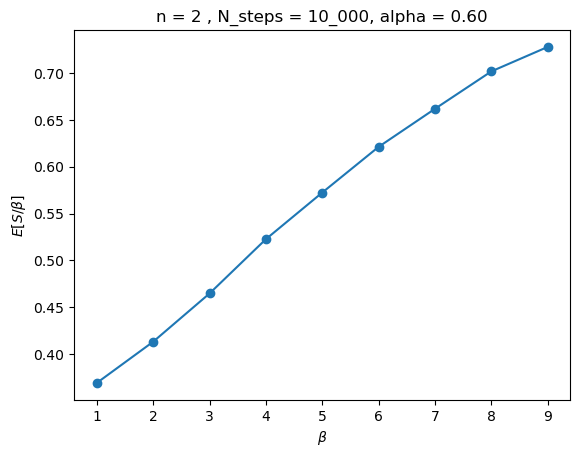

In [5]:
beta = range(1,Nbeta)
plt.plot(beta,obs,'o-')
plt.xlabel(f'$\\beta$')
plt.ylabel(f'$E[S / \\beta]$')
plt.title(f'{n = } , {N_steps = :_d}, {alpha = :.2f}');

## Deformation 

Idea: 

1. deform $S^{2n + 1} \to Q$ via $Z \to \tilde Z = Z + i \zeta_a(Z)$  


2. parametrize $Q$ via $TS^{2n+1}$:

   $$Q \ni \tilde Z(X) = X \sqrt{1 + \lVert Y_a(X) \rVert^2} + i Y_a(X)$$

   where $X \in S^{2n +1 }$ and 
   
   $$Y(X,a) = \frac{a - \langle a, X \rangle X}{1 - \langle a, X \rangle} \in T_X S^{2n + 1} \quad , \quad a \in \mathbb{R}^{2n + 2}$$

3. compute 

   $$\langle \mathcal{O}(Z) \rangle _Q = \langle \det J(X) \mathcal{O}(\tilde Z(X)) e^{- (S(\tilde Z(X)) - S(X))}\rangle _{e^{-S(X)}}$$



To do:

1. choose $a \in \mathbb{R}^{2n + 1}$ fixed constant

2. compute $Y_a(X)$ 

3. compute $\lambda(a,X) = \sqrt{1 + \lVert Y_a(X) \rVert^2}$

4. compute $J_{ij} = \lambda \delta_{ij} + \frac{(M Y)_i X_j}{\lambda} + i M_{ij}$ where

$$M_{ij} = \partial_{X_i}(Y_a(X))_j = \frac{a_i(a_j - X_j) - \delta_{ij} \langle a, X\rangle (1 - \langle a, X\rangle )}{(1 - \langle a, X\rangle)^2}$$



In [3]:
def fuzzy_one(X_samples,W_samples,beta):
    n = (X_samples.shape[1] - 2 ) // 2

    a = np.ones_like(X_samples)

    tildeZ_samples = tildeZ(a,X_samples)

    obs = ( Jac(a,X_samples) * np.exp( - ( S(n,tildeZ_samples,W_samples,beta) - S(n,X_samples,W_samples,beta) ) ) )

    return obs


In [118]:
n = 2

# SETUP OBSERVABLE
beta = 1
fuzzy_one_mean = lambda samples: fuzzy_one(X_samples=samples,W_samples=W_samples,beta=beta).mean()

ones = []
err = []

# INITIAL POINTS ON SPHERE
X0 = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
X0 /= np.linalg.norm(X0)

W0 = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
W0 /= np.linalg.norm(W0)


# SETUP MONTE CARLO
N_steps = 5_000
burnin = 200
skip = 5

# SETUP ERRORS (BOOTSTRAP)
Nboot = 200

# TIME 
t0 = time.time()

for _ in range(50):
    X_samples, W_samples, alpha = MCMC_toy(n=n,Z0=X0,W0=W0,beta=beta,N_steps=N_steps,burnin=burnin,k=skip)

    # a = np.random.normal(size=X_samples.shape) #np.ones_like(X_samples)
    # tildeZ_samples = tildeZ(a,X_samples)
    # obs = Jac(a,X_samples) * np.exp( - ( S(n,tildeZ_samples,W_samples,beta) - S(n,X_samples,W_samples,beta) ) )
    # ones.append(obs.real.mean())
    # err.append(obs.std() / np.sqrt(len(X_samples)))

    ones.append(fuzzy_one_mean(X_samples))
    err.append(bootstrap(X_samples,Nboot=Nboot,f=fuzzy_one_mean)[1])
    

print(f'running time: {time.time() - t0:.2f}s\n')

# print(f'{alpha = }\n')
# print(f'{obs.mean() = } \n')
# print(f'{obs.std() / np.sqrt(len(X_samples)) = }')

100%|██████████| 5000/5000 [00:13<00:00, 383.16it/s]


running time: 851.21s



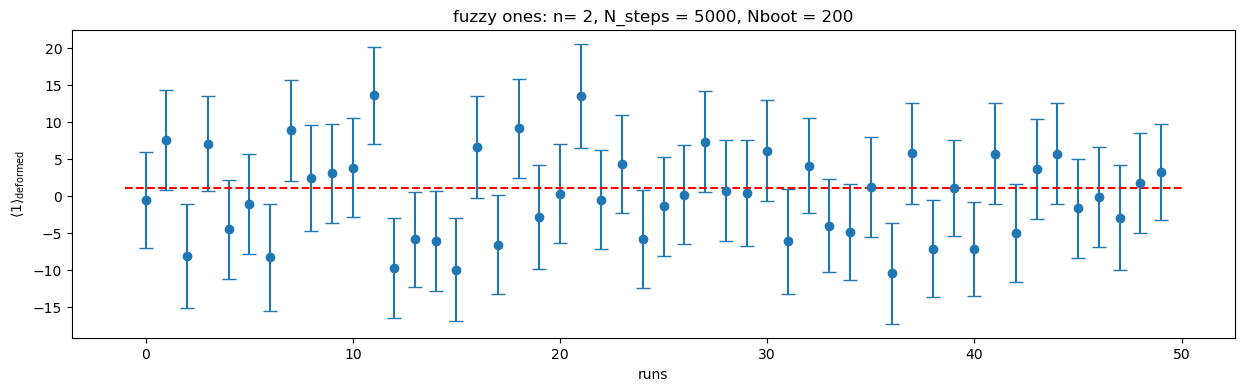

In [119]:
real_ones = [one.real for one in ones]

t = np.arange(len(real_ones))

fig = plt.figure(figsize=(15,4))

plt.errorbar(t, real_ones, yerr=err, fmt='o', capsize=5, label="Data with Error")
plt.hlines(y=1.0,xmin=-1,xmax=len(real_ones),colors='red',ls='--')
plt.title(f'fuzzy ones: {n= }, {N_steps = }, {Nboot = }')
plt.ylabel(r'$\langle 1 \rangle_{\text{deformed}}$')
plt.xlabel('runs');


## Grad Descent Optimization

In [ ]:
# FINDING NULLSTELLEN - PEDESTRIAN WAY
def f(x):
    return x**2

x = torch.tensor(1.5,requires_grad=True) # initial guess

lr = 0.1 # learning rate

epochs = 20 # nb optimization steps

print(f'{x = }')

# OPTIMIZATION 
for epoch in range(epochs):
    y = f(x)
    y.backward()

    with torch.no_grad():
        x -= lr * x.grad
        print(f'{x = } \t {x.grad = }')
    x.grad.zero_()

x = tensor(1.5000, requires_grad=True)
x = tensor(1.2000, requires_grad=True) 	 x.grad = tensor(3.)
x = tensor(0.9600, requires_grad=True) 	 x.grad = tensor(2.4000)
x = tensor(0.7680, requires_grad=True) 	 x.grad = tensor(1.9200)
x = tensor(0.6144, requires_grad=True) 	 x.grad = tensor(1.5360)
x = tensor(0.4915, requires_grad=True) 	 x.grad = tensor(1.2288)
x = tensor(0.3932, requires_grad=True) 	 x.grad = tensor(0.9830)
x = tensor(0.3146, requires_grad=True) 	 x.grad = tensor(0.7864)
x = tensor(0.2517, requires_grad=True) 	 x.grad = tensor(0.6291)
x = tensor(0.2013, requires_grad=True) 	 x.grad = tensor(0.5033)
x = tensor(0.1611, requires_grad=True) 	 x.grad = tensor(0.4027)
x = tensor(0.1288, requires_grad=True) 	 x.grad = tensor(0.3221)
x = tensor(0.1031, requires_grad=True) 	 x.grad = tensor(0.2577)
x = tensor(0.0825, requires_grad=True) 	 x.grad = tensor(0.2062)
x = tensor(0.0660, requires_grad=True) 	 x.grad = tensor(0.1649)
x = tensor(0.0528, requires_grad=True) 	 x.grad = tenso

In [33]:
# FINDING NULLSTELLEN - MODEL

class Nullstellen(nn.Module):
    def __init__(self,f,x0:float):
        super().__init__()

        self.f = f # function whose zeros we want to find 
        self.x = nn.Parameter( torch.tensor([x0]) )

    def forward(self):
        return self.f(self.x)

# HYPERPARAMETER
alpha = 0.01 # learning rate
eps = 1e-8 # stopping cond 
next = True
x0 = np.random.randn()
convergence_steps = 0

# MODEL
model = Nullstellen(f=lambda x: x**2,x0=x0)
optimizer = optim.SGD(model.parameters(),lr=alpha)
print(f'init:\n{model.x}')

# RUN
while next:
    convergence_steps += 1
    y = model()
    y.backward()
    optimizer.step()
    optimizer.zero_grad()
    if y < eps:
        next = False

print(f'\nfinal:\n{model.x}')
print(f'\n{convergence_steps = }')


init:
Parameter containing:
tensor([0.4938], requires_grad=True)

final:
Parameter containing:
tensor([9.7932e-05], requires_grad=True)

convergence_steps = 422


In [5]:
# GENERATE SAMPLES
n = 2 # cmplx dim

# SETUP OBSERVABLE
beta = 1

# INITIAL POINTS ON SPHERE
x0 = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
x0 /= np.linalg.norm(x0)

y0 = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
y0 /= np.linalg.norm(y0)


# SETUP MONTE CARLO
N_steps = 5_000
burnin = 200
skip = 5

x, y, alpha = MCMC_toy(n=n,Z0=x0,W0=y0,beta=beta,N_steps=N_steps,burnin=burnin,k=skip)

100%|██████████| 5000/5000 [00:12<00:00, 398.36it/s]


In [ ]:
def A(phi,beta):
    """
    phi = X, Y 
    """
    N = phi.shape[-2]
    n = (N - 2) // 2 # n in CP^n

    # PUT CST OUTSIDE FCT CALL
    id = torch.eye(N)

    sigma_y = np.array([[0,-1j],[1j,0]]) # 2nd Pauli

    T = id + torch.tensor( block_diag(*[sigma_y for _ in range(n+1)]) ) 
    # END CST

    X = phi[:,0]
    Y = phi[:,1]

    hXY = ( X.transpose(-1,-2) @ (T @ Y) ).flatten()

    hYX =  ( Y.transpose(-1,-2) @ (T @ X) ).flatten()

    return - beta * hXY * hYX
    
def fuzzy_one(a,phi,beta):
    X = phi
    N = x.shape[1] # 2n + 2

    # ALGEBRA
    inner_aX = a.transpose(-1,-2) @ X
    outer_aX = a @ X.transpose(-1,-2)

    inner_XX = X.transpose(-1,-2) @ X
    outer_XX = X @ X.transpose(-1,-2)

    Y = a - inner_aX / inner_XX * X # P^perp(a,X)

    inner_YY = Y.transpose(-1,-2) @ Y

    id = torch.eye(N)

    # ACTION FUNCTIONAL

    A0 = A(X,beta)


    # COMPLEXIFICATION 

    tildeX = X * torch.sqrt(1 + inner_YY) + 1j*Y

    Atilde = A(tildeX,beta)

    # JACOBIAN

    lam = torch.sqrt(1 + inner_YY) # shape (samples,2,1,1), torch.tensor

    M = - id * inner_aX / inner_XX - outer_aX / inner_XX +  2*inner_aX * outer_XX / inner_XX**2

    J = id*lam + (M @ Y) @ X.transpose(-1,-2) / lam + 1j*M

    det = torch.det(J) # shape (samples, #particles) -> need to multiply
    detJ = det / lam.squeeze(dim=(-1,-2))**2 

    detJ = torch.prod(detJ,dim=-1) # shape (samples,)

    assert len(detJ.shape) == 1, f'detJ has wrong dim: {detJ.shape} but must be 1' 


    OO = ( detJ * torch.exp( - ( Atilde - A0 ) ) ) # observable 

    return OO

def real2cmplx(phi):
    # phi.shape = (... , N, 1)

    z = phi[...,::2,:] + 1j*phi[...,1::2,:]
    zbar = phi[...,::2,:] - 1j*phi[...,1::2,:]

    return (z,zbar)

def two_pt_fct(phi):
    zeta, zetabar = real2cmplx(phi)

    z = zeta[:,0]
    zbar = zetabar[:,0]
    w = zeta[:,1]
    wbar = zetabar[:,1]

    return (z[:,0]*wbar[:,0]*w[:,1]*zbar[:,1]).squeeze(dim=-1) 

def one_pt_fct(phi):
    zeta, zetabar = real2cmplx(phi)

    z = zeta[:,0]
    zbar = zetabar[:,0]
    
    return (z[:,0]*zbar[:,1]).squeeze(dim=-1) 

def def_obs(obs):
    
    def compute(a,phi,beta):
        X = phi
        N = x.shape[1] # 2n + 2

        # ALGEBRA
        inner_aX = a.transpose(-1,-2) @ X
        outer_aX = a @ X.transpose(-1,-2)

        inner_XX = X.transpose(-1,-2) @ X
        outer_XX = X @ X.transpose(-1,-2)

        Y = a - inner_aX / inner_XX * X # P^perp(a,X)

        inner_YY = Y.transpose(-1,-2) @ Y

        id = torch.eye(N)

        # ACTION FUNCTIONAL

        A0 = A(X,beta)


        # COMPLEXIFICATION 

        tildeX = X * torch.sqrt(1 + inner_YY) + 1j*Y

        Atilde = A(tildeX,beta)

        # JACOBIAN

        lam = torch.sqrt(1 + inner_YY) # shape (samples,2,1,1), torch.tensor

        M = - id * inner_aX / inner_XX - outer_aX / inner_XX +  2*inner_aX * outer_XX / inner_XX**2

        J = id*lam + (M @ Y) @ X.transpose(-1,-2) / lam + 1j*M

        det = torch.det(J) # shape (samples, #particles) -> need to multiply
        detJ = det / lam.squeeze(dim=(-1,-2))**2 

        detJ = torch.prod(detJ,dim=-1) # shape (samples,)

        assert len(detJ.shape) == 1, f'detJ has wrong dim: {detJ.shape} but must be 1' 


        OO = (obs(tildeX) * detJ * torch.exp( - ( Atilde - A0 ) ) ) # observable 

        return OO
    
    return compute

def grab(x):
    return x.detach().cpu().numpy()

def loss(obs):
    return obs.var()

def logloss(obs):
    return torch.log(obs.var())

In [ ]:
# SDG OPTIMIZATION 
class DefObs(nn.Module):
    def __init__(self,obs,a,beta):
        """
    
        obs = observable
        a,b = (contour) deformation parameters 
        """
        super().__init__()

        self.a = nn.Parameter(a) # deformation parameter(s)
        self.beta = beta
        self.obs = obs

    def forward(self,samples):
        a_ = self.a.cdouble().unsqueeze(0)

        return self.obs(a_,samples,self.beta)

100%|██████████| 1000/1000 [00:08<00:00, 112.76it/s]


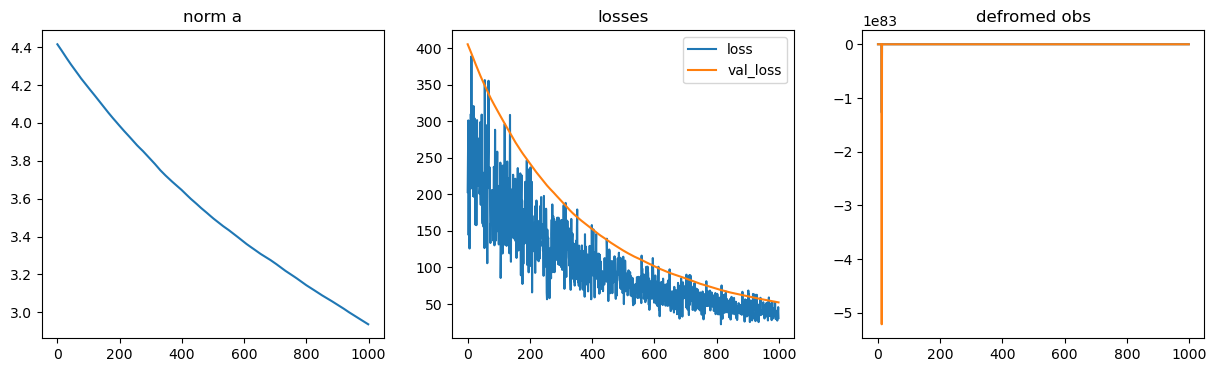

In [ ]:
# MODEL
# p1 = torch.tensor(x,dtype=complex)
# p2 = torch.tensor(y,dtype=complex)

phi = torch.tensor(np.stack([x,y],axis=1),dtype=complex)

a = 0.0*torch.randn(*phi.shape[1:]) # 2 deform params 

beta = 1.0
alpha = 1e-3


split = int(0.7*phi.shape[0])
phi_train = phi[:split]
phi_val = phi[split:]


model = DefObs(obs=def_obs(one_pt_fct), a=a, beta=beta)
optimizer = optim.Adam(model.parameters(),lr=alpha)


anorm = []
losses_train = []
losses_val = []
observable = []

epochs = 1_000

loss_fct = logloss

batch_size = 32

# RUN
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad() # clear grads

    # MINI-BATCHING
    minibatch = np.random.randint(low=0,high=len(phi_train),size=batch_size)

    # TRAIN
    deformed_obs = model(samples=phi_train[minibatch])
    loss_train =loss_fct(deformed_obs)
    loss_train.backward()

    # print(f'grad: {model.a.grad}\n')
    with torch.no_grad():
        observable.append(grab(deformed_obs).mean())

    optimizer.step()

    # VALIDATION
    with torch.no_grad():
        deformed_obs_val = model(samples=phi_val)
        loss_val = loss_fct(deformed_obs_val)
        
        
    
    losses_train.append(grab(loss_train))
    losses_val.append(grab(loss_val))
    anorm.append(np.linalg.norm(grab(a).ravel()))

        

# PLOT

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,4))

ax[0].plot(anorm)
ax[0].set_title('norm a')
ax[1].plot(losses_train,label='loss')
ax[1].plot(losses_val,label='val_loss')
ax[1].legend()
ax[1].set_title('losses')
ax[2].plot([z.real for z in observable],label='re')
ax[2].plot([z.imag for z in observable],label='imag')
ax[2].set_title('defromed obs');

## Defining the Model

### Notation:

$n = \dim_{\mathbb{C}}$

$N = 2n + 2 = \dim_{\mathbb{R}}$

$z, w \in \mathbb{CP}^n \cong \mathbb{R}^{2n + 2} \ni Z, W$

parametrisation: $\tilde Z = X \sqrt{1 + \lVert Y(X)\rvert^2} + i Y(X)$ where $X \in \mathbb{R}^{2n + 2}$



In [2]:
# HELPER FUNCTIONS

def rho(z):
    """
    Real representation of Mat(n x n,C) in terms of Mat( 2n x 2n, R) using z = a + i b => [[a,-b],[b,a]] for any complex entry z 
    """
    assert z.shape[-2] == z.shape[-1], f'z must have shape (n,n) has {tuple(z.shape[-2:])}'
   
    *batch_dims, n, m = z.shape
    double_last_dim = (2*n, 2*m)
    
    z_ = torch.empty(*batch_dims,*double_last_dim)
    
    re = z.real
    im = z.imag

    z_[...,0::2,0::2] = re
    z_[...,0::2,1::2] = -im
    z_[...,1::2,0::2] = im
    z_[...,1::2,1::2] = re

    return z_

def rnd_su(shape:list):
    """
    Creates batch-wise a random su(n) matrix. The dimension of the matrix are the last two dimensions.
    """

    assert shape[-2] == shape[-1], f'last two dimensions must be equal but got {tuple([shape[-2],shape[-1]])}'
    omega = torch.randn(*shape,dtype=complex)
    omega -= torch.diag_embed(torch.diagonal(omega,dim1=-2,dim2=-1))
    omega = omega - torch.conj(omega.transpose(-2,-1))

    return omega

def grab(x):
    return x.detach().cpu().numpy()

def loss(obs):
    return obs.var()

def logloss(obs):
    return torch.log(obs.var())

# OBSERVABLES
def real2cmplx(phi):
    # phi.shape = (... , N, 1)

    z = phi[...,::2,:] + 1j*phi[...,1::2,:]
    zbar = phi[...,::2,:] - 1j*phi[...,1::2,:]

    return (z,zbar)
    
def cmplx2real(z):
    re = z.real
    im = z.imag
    Xshape = [elem for elem in z.shape]
    Xshape[-2] *= 2
    # Xshape = torch.tensor(Xshape)

    X = torch.zeros(*Xshape)
    X[...,::2,:] = re
    X[...,1::2,:] = im

    return X

def fuzzy_one(phi):
    return 1.

def fuzzy_zero(phi,i:int,j:int):
    """
    Observable z_i \\bar z_j

    Parameters:
    -----------
    phi: torch.tensor
        Batch of real fields (vectors (...,2n+1,1))

    i: int
        Component z_i

    j: int
        Component \\bar z_j
    """

    Z = phi[:,0] # real rep of z

    # COMPLEX VARIABLES
    z, zbar = real2cmplx(Z) # (*batch,dim_C,1) 

    # COMPLEX OBSERVABLE
    O = (z[...,i,:]*zbar[...,j,:]) # z_i \bar z_j (*batch,,1)

    return O


In [70]:
# SDG OPTIMIZATION 
class ZeroDModel(nn.Module):

    @staticmethod
    def create_samples(n:int, phi0:torch.tensor, beta:float, N_steps:int,burnin:int,k:int) -> torch.tensor:
        """
        :param n: complex dimension CP^n 
        :type n: int

        :param phi0: initial state
        :type phi0:
        """

        def R(t:float) -> torch.tensor:
            """
            2x2 roation matrix 

            :param t: rotation angle
            :type t: float

            :returns: rotation matrix np.array([[cos(t),-sin(t)],[sin(t),cos(t)]])
            :rtype: np.ndarray
            """

            c = torch.cos(t)
            s = torch.sin(t)

            return torch.tensor([[c,-s],[s,c]])

        def sweep_sphere(phi:list,pairs:list,f) -> float:  
            """
            sweeping the sphere

            :param n: complex dimension CP^n
            :type n: int
            """

            alpha = 0 # number accepted

            # LOOP OVER COMPONENTS 
            for pair in pairs:
                a,b = pair # unpack indices
                phi_old = phi[-1] # current state 

                # SAMPLE 2x2 ROTATION ANGLE
                theta = torch.randn(1)

                # ROTATE COMPONENT
                v = torch.tensor([phi_old[a],phi_old[b]])
                vnew = R(theta) @ v

                # PROPOSE NEW STATE
                phi_new = phi_old.detach().clone()
        
                phi_new[a] = vnew[0]
                phi_new[b] = vnew[1]
            
                # ACCEPTENCE PROBABILITIES
                A = torch.minimum(torch.tensor(1), f(phi_new.unsqueeze(0)) / (f(phi_old.unsqueeze(0))) ) # unsqueeze since f takes list of vectors: shape = (smaples,2n+2,1)

                # CHECK IF ACCEPTED
                p = torch.rand(1) # draw vector of uniform rnds
                
                if p <= A : # accept if p < A
                    phi.append(phi_new)
                    alpha += 1
                else:
                    phi.append(phi_old)

            return alpha / len(pairs)
    
        def h(Z,W):
            return ( Z.transpose(-2,-1).cfloat() @ ( T @ W.cfloat()) ).flatten()
        
        def S(Z,W):
            return (-beta * h(Z,W) * h(W,Z)).real
        
        N = 2*n + 2 # real dimension (before quotient by C^*)
        pairs = list(combinations(np.arange(N),2)) # indices of pairs to rotate

        # LIN ALG NEEDED FOR ACTION
        id = torch.eye(2*(n + 1))
        sigma_y = torch.tensor([[0,-1j],[1j,0]])

        T = id + torch.block_diag(*[sigma_y for _ in range(n+1)]) # dtype = cfloat 
        

        # SETUP
        Z0 = phi0[0] # (nb fields, dim, 1)
        W0 = phi0[1]

        Z = [Z0] 
        W = [W0]

        alpha = 0 # number accepted

        expSw = lambda z: torch.exp( -S(z,W[-1]))    # w fixed
        expSz = lambda w: torch.exp( -S(Z[-1],w))    # z fixed

        for _ in tqdm(range(N_steps)): # tqdm for progress bar

            alpha += sweep_sphere(phi=Z,pairs=pairs,f=expSw) 
            alpha += sweep_sphere(phi=W,pairs=pairs,f=expSz)
        
        samples_Z, samples_W = (torch.stack(Z,dim=0)[burnin::k], torch.stack(W,dim=0)[burnin::k])

        acception_rate = alpha / (2*N_steps) 

        return  (torch.stack([samples_Z, samples_W],dim=1), acception_rate)

    def __init__(self,dim_C:int,deformation:str,observable:Callable,beta:float,deformation_param:torch.tensor=None):
        """
    
        obs = observable
        a,b = (contour) deformation parameters 
        """
        super().__init__()

        # SAMPLES
        # self.samples = samples

        # DIMENSIONS 
        self.dim_C = dim_C
        self.dim_R = 2*self.dim_C 

        # LIN ALG
        self.id = torch.eye(self.dim_R+2)
        sigma_y = np.array([[0,-1j],[1j,0]]) # 2nd Pauli
        self.T = self.id + torch.tensor( block_diag(*[sigma_y for _ in range(self.dim_C+1)]) ) # linear operator used in def of action

        # HYPERPARAMETERS
        self.beta = beta
        self.obs = observable # observable (only takes 1 input)
        self.deformation = deformation
        # if self.deformation == 'torus':
        #     self.Omega = torch.tensor([[0,1],[-1,0]])

        # PARAMETERS
        if deformation_param:
            self.a = nn.Parameter(deformation_param) # deformation parameter(s)
        elif deformation == 'linear':
            self.a = nn.Parameter(0.1*torch.randn(*phi.shape[1:]))
        elif deformation == 'homogeneous':
            a_ = self.rnd_su([2,n+1,n+1])
            self.a = nn.Parameter(0.1*self.rho(a_))
        elif deformation == 'torus':
            a_ = 0.1j*torch.diag_embed(torch.randn(2,n+1))
            self.a = nn.Parameter(self.rho(a_))
            self.deformation = 'homogeneous'
        else:
            raise Exception('Invalid deformation')
        
    
    def grab(self,x):
        return x.detach().cpu().numpy()

    def get_deformation_param(self):
        return self.grab(self.a)
    
    def set_deformation_param(self,a):
        self.a = a

    def real2cmplx(self,phi):
        # phi.shape = (... , N, 1)

        z = phi[...,::2,:] + 1j*phi[...,1::2,:]
        zbar = phi[...,::2,:] - 1j*phi[...,1::2,:]

        return (z,zbar)
    
    def cmplx2real(self, z):
        re = z.real
        im = z.imag
        Xshape = [elem for elem in z.shape]
        Xshape[-2] *= 2
        # Xshape = torch.tensor(Xshape)

        X = torch.zeros(*Xshape)
        X[...,::2,:] = re
        X[...,1::2,:] = im

        return X

    def rho(self, z):
        """
        Real representation of Mat(n x n,C) in terms of Mat( 2n x 2n, R) using z = a + i b => [[a,-b],[b,a]] for any complex entry z 
        """
        assert z.shape[-2] == z.shape[-1], f'z must have shape (n,n) has {tuple(z.shape[-2:])}'
    
        *batch_dims, n, m = z.shape
        double_last_dim = (2*n, 2*m)
        
        z_ = torch.empty(*batch_dims,*double_last_dim)
        
        re = z.real
        im = z.imag

        z_[...,0::2,0::2] = re
        z_[...,0::2,1::2] = -im
        z_[...,1::2,0::2] = im
        z_[...,1::2,1::2] = re

        return z_

    def rnd_su(self,shape:list):
        """
        Creates batch-wise a random su(n) matrix. The dimension of the matrix are the last two dimensions.
        """

        assert shape[-2] == shape[-1], f'last two dimensions must be equal but got {tuple([shape[-2],shape[-1]])}'
        omega = torch.randn(*shape,dtype=complex)
        omega -= torch.diag_embed(torch.diagonal(omega,dim1=-2,dim2=-1))
        omega = omega - torch.conj(omega.transpose(-2,-1)) # zero diagonal
        omega += torch.diag_embed(1j*torch.randn(*shape[:-2],shape[-2])) # add random purely imaginary diagonal
        omega[...,0,0] -= omega.diagonal(dim1=-2, dim2=-1).sum(-1) # ensure trace = zero (set first element to -sum of rest)

        return omega

    def A(self,phi):
        """
        phi = X, Y (samples, fields, dim, 1)
        """

        X = phi[:,0]
        Y = phi[:,1]

        hXY = ( X.transpose(-1,-2) @ (self.T @ Y) ).flatten()

        hYX =  ( Y.transpose(-1,-2) @ (self.T @ X) ).flatten()

        return - self.beta * hXY * hYX

    # DEFORMATIONS
    def linear(self,phi,a):
        X = phi

        # ALGEBRA
        inner_aX = a.transpose(-1,-2) @ X
        outer_aX = a @ X.transpose(-1,-2)

        inner_XX = X.transpose(-1,-2) @ X
        outer_XX = X @ X.transpose(-1,-2)

        Y = a - inner_aX / inner_XX * X # P^perp(a,X)

        inner_YY = Y.transpose(-1,-2) @ Y

        # COMPLEXIFICATION 

        lam = torch.sqrt(1 + inner_YY) # shape (samples,2,1,1)

        tildeZ = X * lam + 1j*Y

        # JACOBIAN

        M = - self.id * inner_aX / inner_XX - outer_aX / inner_XX +  2*inner_aX * outer_XX / inner_XX**2

        J = self.id*lam + (M @ Y) @ X.transpose(-1,-2) / lam + 1j*M

        det = torch.det(J) # shape (samples, #particles) -> need to multiply
        detJ = det / lam.squeeze(dim=(-1,-2))**2 

        detJ = torch.prod(detJ,dim=-1) # total Jacobian, shape (samples,)

        assert len(detJ.shape) == 1, f'detJ has wrong dim: {detJ.shape} but must be 1' 

        return (tildeZ, detJ) 

    def torus(self,phi,a):
        
        X = phi

        # DEFORMATION
        assert a.shape[-1] == 1, f'expected (batched) column vector got {tuple(a.shape[-2:])}'

        a_cmplx = 1j*torch.diag_embed(a.squeeze(-1))
        aOmega = self.rho(a_cmplx)

        Y = aOmega.cdouble() @ X
        
        # ALGEBRA
        inner_YY = Y.transpose(-1,-2) @ Y 
        outer_XX = X @ X.transpose(-1,-2) 

        # COMPLEXIFICATION 
        lam = torch.sqrt(1 + inner_YY) # shape (samples,2,1,1)

        tildeZ = X * lam + 1j*Y
    
        # JACOBIAN

        J = self.id*lam + torch.linalg.norm(a)**2 * outer_XX / lam - 1j*aOmega
        det = torch.det(J) # shape (samples, #particles) -> need to multiply
        detJ = det / lam.squeeze(dim=(-1,-2))**2 

        detJ = torch.prod(detJ,dim=-1) # total Jacobian, shape (samples,)

        assert len(detJ.shape) == 1, f'detJ has wrong dim: {detJ.shape} but must be 1' 
        
        return (tildeZ, detJ)

    def homogeneous(self,phi,a):
        # needs to be worked out -> using su(N) matrix works fine with real2cmplx and cmplx2real but then need Omega = rho(xi) for Jacobian
        assert a.shape[-1] == phi.shape[-2] and a.shape[-2] == phi.shape[-2], f'a last (i.e. non-batch) dimensions must be {2*tuple([phi.shape[-2]])} but has shape {a.shape}'

        X = phi
         
        # DEFORMATION
        Y = a @ X

        # ALGEBRA
        inner_YY = Y.transpose(-1,-2) @ Y 
        outer_XX = X @ X.transpose(-1,-2)

        # COMPLEXIFICATION 
        lam = torch.sqrt(1 + inner_YY) # shape (samples,2,1,1)

        tildeZ = X * lam + 1j*Y
    
        # JACOBIAN

        J = self.id*lam - (a @ a) @ outer_XX / lam - 1j*a
        det = torch.det(J) # shape (samples, #particles) -> need to multiply
        detJ = det / lam.squeeze(dim=(-1,-2))**2 

        detJ = torch.prod(detJ,dim=-1) # total Jacobian, shape (samples,)

        assert len(detJ.shape) == 1, f'detJ has wrong dim: {detJ.shape} but must be 1' 
        
        return (tildeZ, detJ)
        
    def deformed_obs(self,phi,a):

        A0 = self.A(phi)

        if self.deformation == 'linear':
            tildeZ, detJ = self.linear(phi,a)

        elif self.deformation == 'torus':
            tildeZ, detJ = self.torus(phi,a)

        elif self.deformation == 'homogeneous':
            tildeZ, detJ = self.homogeneous(phi,a)

        Atilde = self.A(tildeZ)

        OO = (self.obs(tildeZ) * detJ * torch.exp( - ( Atilde - A0 ) ) ) # observable 

        return OO

    def forward(self,samples):
        a_ = self.a.cdouble().unsqueeze(0)
        return self.deformed_obs(samples,a_)

In [4]:
# GENERATING SAMPLES
n = 2
beta = 1
N_steps = 5_000
burnin = 100
skip = 5

phi0 = torch.randn(2,(2*n + 2),1)
phi0 /= torch.linalg.vector_norm(phi0, dim=1, keepdim=True)

phi, alpha = ZeroDModel.create_samples(n=n,phi0=phi0,beta=beta,N_steps=N_steps,burnin=burnin,k=skip)


100%|██████████| 5000/5000 [00:13<00:00, 373.77it/s]


**!! Remarks !!** 

* should rename $a$ to $\omega$.

* It would be interesting to see if we could use more Lie theory, namely the rootspace decomposition! I'll try to work this out

In [ ]:
# MODEL (n=2) 

# SET HYPERPARAMETERS
beta = 1.0
alpha = 1e-4
i,j = 0, 1 # parameter for fuzzy zero
obs = lambda phi: fuzzy_zero(phi,i,j)
# obs = fuzzy_one

# device = 'mps' if torch.backends.mps.is_available() else 'cpu' # run on GPU if available | mac mX chip specific !! MPS DOES NOT SUPPORT COMPLEX DTYPES

# SET PARAMETERS

deformation = 'homogeneous'
# LINEAR DEFORMATION (! works well with logloss)
# a = 0.1*torch.randn(*phi.shape[1:]) # deform params linear
# deformation = 'linear'

# U(n+1) TORUS DEFORMATION (! works better with loss)
# a = 0.1*torch.randn(phi.shape[-3],phi.shape[-2]//2,phi.shape[-1])
# deformation = 'torus'

# HOMOGENEOUS DEFORMATION
# a = rnd_su([2,n+1,n+1])
# a = 0.1*rho(a)
# deformation = 'homogeneous'

# TORUS DEFORMATION VIA HOMOGENEOUS DEFORMAITON
# a = 0.1j*torch.diag(torch.randn(n+1))
# a = rho(a)
# deformation = 'homogeneous'

# SETUP MODEL
model = ZeroDModel(dim_C=n,observable=obs,deformation=deformation,beta=beta)

a0 = model.get_deformation_param().copy() # get initial deformation parameter before training

optimizer = optim.Adam(model.parameters(),lr=alpha)

# TRAIN-VALIDATION-SPLIT
split = int(0.7*phi.shape[0])
phi_train = phi[:split]
phi_val = phi[split:]

# SET LOSS FUNCTION
loss_fct = loss
loss_name = 'loss' if loss_fct == loss else 'logloss'

# SET BATCH SIZE
batch_size = 32

# SET EPOCHS
epochs = 5_000

# FOR ANALYSIS
anorm = []
losses_train = []
losses_val = []
observable = []
observable_var = []


# TRAINING
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad() # clear grads

    # MINI-BATCHING
    minibatch = np.random.randint(low=0,high=len(phi_train),size=batch_size)

    # TRAIN
    deformed_obs = model(samples=phi_train[minibatch].cdouble())

    loss_train = loss_fct(deformed_obs)
    loss_train.backward()

    with torch.no_grad():
        observable.append(grab(deformed_obs).mean())
        observable_var.append(grab(deformed_obs).var())

    optimizer.step()

    # VALIDATION
    with torch.no_grad():
        deformed_obs_val = model(samples=phi_val.cdouble())

        loss_val = loss_fct(deformed_obs_val)
        
    losses_train.append(grab(loss_train))
    losses_val.append(grab(loss_val))

    anorm.append(np.linalg.norm(model.get_deformation_param().ravel())) # get vector norm if deformation is 'linear' or matrix norm if 'homogeneous' or 'torus'

    # if deformation == 'linear':
    #     anorm.append(np.linalg.norm(model.get_deformation_param().ravel())) # get vector norm
    # else:
    #     matrix_norms = np.linalg.norm(model.get_deformation_param()) # get matrix norm
    #     anorm.append(matrix_norms.sum())
    
# VARIANCE OF UNDEFORMED MODEL
undeformed_obs = obs(phi)

# GET DEFORMATION PARAMETER AFTER TRAINING 
af = model.get_deformation_param() # get initial deformation parameter before training


  0%|          | 8/5000 [00:00<05:54, 14.08it/s]

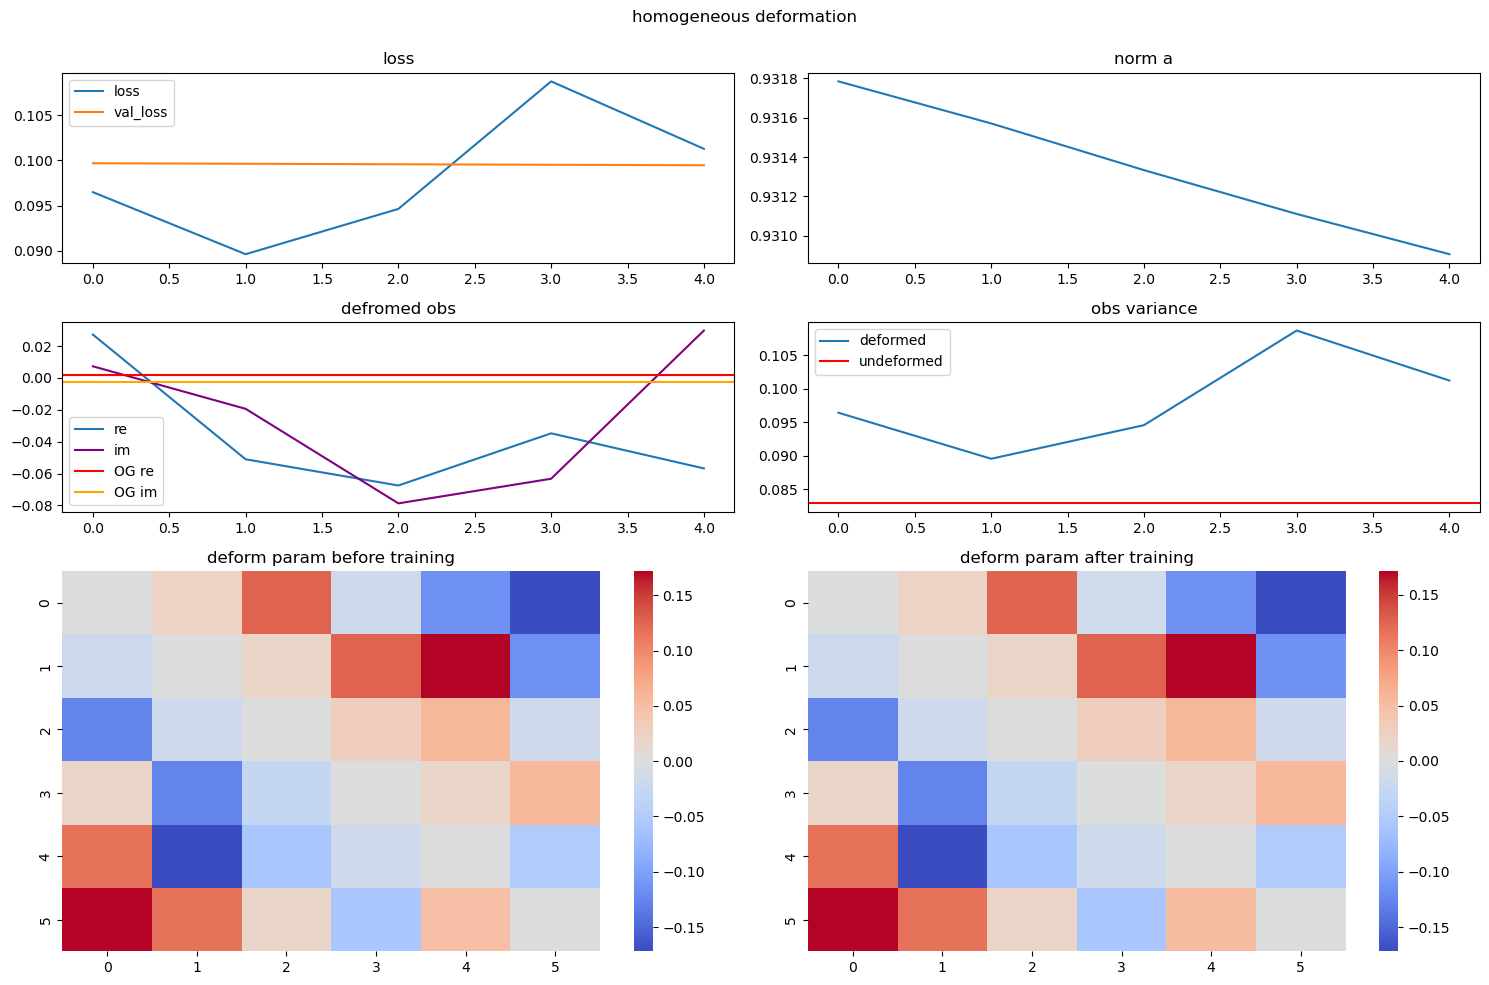

In [76]:
# PLOT

fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(15,10),gridspec_kw={'height_ratios': [1, 1, 2]})

plt.suptitle(deformation + ' deformation\n')
ax[0,1].plot(anorm)
ax[0,1].set_title('norm a')

ax[0,0].plot(losses_train,label='loss')
ax[0,0].plot(losses_val,label='val_loss')
ax[0,0].legend()
ax[0,0].set_title(loss_name)
ax[0,0].legend()

ax[1,0].plot([z.real for z in observable],label='re')
ax[1,0].plot([z.imag for z in observable],label='im',color='purple')
ax[1,0].axhline(y=undeformed_obs.mean().real,xmin=0,xmax=phi.shape[0],label='OG re',color='red')
ax[1,0].axhline(y=undeformed_obs.mean().imag,xmin=0,xmax=phi.shape[0],label='OG im',color='orange')
ax[1,0].set_title('defromed obs')
ax[1,0].legend()

ax[1,1].plot([z.real for z in observable_var],label='deformed')
ax[1,1].axhline(y=undeformed_obs.var(),xmin=0,xmax=phi.shape[0],label='undeformed',color='red')
ax[1,1].set_title('obs variance')
ax[1,1].legend()

# if deformation == 'homogeneous' or deformation == 'torus':
sns.heatmap(data=a0[0],ax=ax[2,0],cmap='coolwarm')
ax[2,0].set_title('deform param before training')
sns.heatmap(data=af[0],ax=ax[2,1],cmap='coolwarm')
ax[2,1].set_title('deform param after training')

plt.tight_layout();

## Tests

In [562]:
# CREATING BLOCK DIAG MATRICES WITH BATCHING blkdiag
a = torch.randint(low=0,high=9,size=(1,3,2,2))
b = torch.randint(low=0,high=9,size=(1,3,2,2))
c = torch.randint(low=0,high=9,size=(1,3,2,2))

print(f'{a.shape = }\n')
arrs = [a,b,c]
shapes = np.array([i.shape for i in arrs])

print(f'{shapes = }\n')

print(f'{shapes[0,:-2] = }\n')

print(f'{list(shapes[0,:-2])+[shapes[:, -1].sum(), shapes[:,-2].sum()]}\n')

# np.zeros([shapes[:, i].sum() for i in range(len(arrs))])

# print(f'{a = }\n')
# print(f'{b = }\n')
# print(f'{c = }\n')
M = blkdiag(arrs)
print(f'{M.shape = }\n')
print(M)



a.shape = torch.Size([1, 3, 2, 2])

shapes = array([[1, 3, 2, 2],
       [1, 3, 2, 2],
       [1, 3, 2, 2]])

shapes[0,:-2] = array([1, 3])

[1, 3, 6, 6]

M.shape = torch.Size([1, 3, 6, 6])

tensor([[[[7., 5., 0., 0., 0., 0.],
          [3., 5., 0., 0., 0., 0.],
          [0., 0., 6., 5., 0., 0.],
          [0., 0., 8., 3., 0., 0.],
          [0., 0., 0., 0., 6., 1.],
          [0., 0., 0., 0., 0., 8.]],

         [[3., 2., 0., 0., 0., 0.],
          [8., 4., 0., 0., 0., 0.],
          [0., 0., 0., 8., 0., 0.],
          [0., 0., 0., 6., 0., 0.],
          [0., 0., 0., 0., 0., 5.],
          [0., 0., 0., 0., 2., 4.]],

         [[1., 5., 0., 0., 0., 0.],
          [1., 2., 0., 0., 0., 0.],
          [0., 0., 6., 7., 0., 0.],
          [0., 0., 4., 7., 0., 0.],
          [0., 0., 0., 0., 8., 7.],
          [0., 0., 0., 0., 1., 0.]]]])


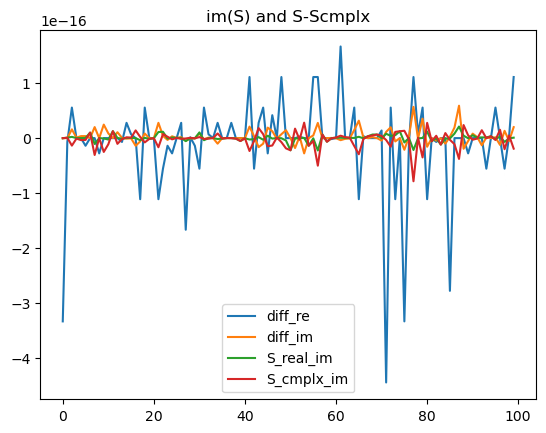

In [36]:
# TESTING S : REAL VS CMPLX

# REAL SETUP
n = 3 # complex dimension of CP^n

diff_re, diff_im, S_real_im, S_cmplx_im = [], [], [], []

for i in range(100):
    Z = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
    Z/= np.linalg.norm(Z)

    W = np.random.normal(loc=0,scale=1,size = (2*n + 2)).reshape(-1,1)
    W /= np.linalg.norm(W)


    # COMPARISON WITH COMPLEX ACTION
    reZ = Z[0::2]
    imZ = Z[1::2]

    reW = W[0::2]
    imW = W[1::2]

    z = np.array([a + b*1j for a,b in zip(reZ,imZ)])
    w = np.array([a + b*1j for a,b in zip(reW,imW)])

    # DIM NEEDED FOR S (samples,2n+2,1)
    Z = Z[np.newaxis,:,:]
    W = W[np.newaxis,:,:]

    # print(f'{S(n,Z,W,beta=1) = }')
    # print(f'{Scmplx(z.flatten(),w.flatten(),beta=1) = }')
    diff_re.append((S(n,Z,W,beta=1) - Scmplx(z.flatten(),w.flatten(),beta=1)).real)
    diff_im.append((S(n,Z,W,beta=1) - Scmplx(z.flatten(),w.flatten(),beta=1)).imag)
    S_real_im.append(S(n,Z,W,beta=1).imag)
    S_cmplx_im.append(Scmplx(z.flatten(),w.flatten(),beta=1).imag)

# print(f'S - Scmpl = {(S(n,Z,W,beta=1) - Scmplx(z.flatten(),w.flatten(),beta=1)).real}')
names = ['diff_re','diff_im','S_real_im','S_cmplx_im']
i = 0
for f in [diff_re,diff_im,S_real_im,S_cmplx_im]:
    plt.plot(f,label=names[i])
    i+=1

plt.title('im(S) and S-Scmplx')
plt.legend();

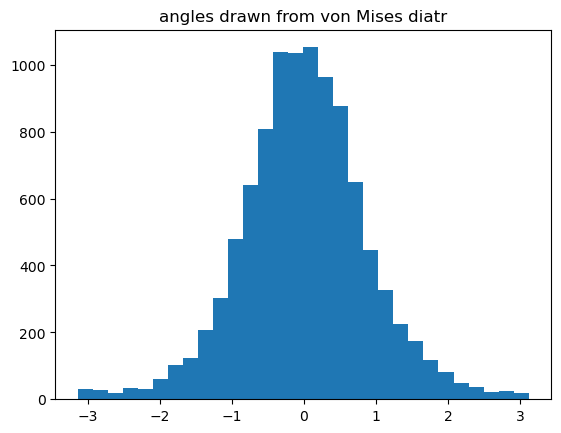

In [52]:
data = np.random.vonmises(0.0,2,size=10_000)
plt.hist(data,bins=30)
plt.title('angles drawn from von Mises diatr');

In [53]:
# TESTING DIFFS
x = np.array([1,0,0])
y = np.array([0,1,0])

u = np.array([1,0,0])
v = np.array([0,1,0])

z = 1 + 2j

x_prime,y_prime = invPsi(Psi((x,y)))
print(f'{x_prime - x = }')
print(f'{y_prime - y = }')

w = Psi(invPsi(z))
print(f'{w - z = }')

x_prime - x = array([0., 0., 0.])
y_prime - y = array([0., 0., 0.])
w - z = 0j
